In [20]:
BUILTIN_SIMULATION = 'diffraction'  # הפעלת הגדרות השמורות לסימולציות ספציפיות
# Can be 'reflection', 'diffraction', 'interference' or 'random drops'

In [21]:
# ייבוא ספריות שונות
from matplotlib import pyplot as plt, animation, cm, colors
import numpy as np
from numpy import pi
from random import randint

In [22]:
# איתחול ערכים שונים הרלוונטיים לגזרה בה מחשבים ולמהירות הגל
x0 = 0
xf = 400
y0 = 0
yf = 400
t0 = 0
tf = 320

M = 384  # time steps
N = 401  # space steps

v = 0.7  # wave speed
b = 0.01  # מקדם החיכוך

In [23]:
# מחלקות שונות המספקות ממשק נוח לשימוש בסימולציה
class Drop:  # מחלקה של טיפת מים
    def __init__(self, wavelength: int, amplitude: int, x: int, y: int, frame=-1, once=False):
        self.h = wavelength
        self.A = amplitude
        self.x = x
        self.y = y
        self.frame = frame
        self.once = once
        self.T = self.h//v

class Tsunami:  # מחלקה של צונאמי - בעצם גל מחזורי שבא מקצה אחד של המשטח
    def __init__(self, wavelength: int, amplitude: int, origin: str):
        self.h = wavelength
        self.A = amplitude
        self.origin = origin

class Wall:  # מחלקה של חומה, דרכה גלים אינם יכולים לעבור
    def __init__(self, x0: int, xf: int, y0: int, yf: int):
        self.x0 = x0
        self.xf = xf
        self.y0 = y0
        self.yf = yf

In [24]:
ELEMENTS = {'drops': [Drop(50, 10, N//2, N//2)], 'tsunamis': [], 'walls': []}  # מילון של האלמנטים המשמשים בסימולציה

In [25]:
GRAPH_TITLE = f'2D Simulation (b={b})'  # כותרת הגרף
CREATE_VIDEO = True  # האם ליצור סרטון או לא
VIDEO_NAME = 'wave'  # שם הסרטון

In [26]:
#  פונקצייה המגדירה כיצד ייראה המשטח בהתחלה
def I(x, y):
    """Initial condition"""
    return 0

In [27]:
# הגדרת ההגדרות השמורות לסימולציות אם נבחרה סימולציה מסוימת

if BUILTIN_SIMULATION == 'reflection':  # החזרה של גל מים מעגלי בודד מקצה המשטח
    A = int(input('Enter amplitude: '))

    GRAPH_TITLE = 'Reflection'
    ELEMENTS = {'drops': [Drop(-1, A, N//10, N//2, frame=1, once=True)],
                'tsunamis': [],
                'walls': []}

elif BUILTIN_SIMULATION == 'diffraction':  # עקיפה בסדק/ים
    h = int(input('Enter wavelength: '))
    A = int(input('Enter amplitude: '))
    w = int(input('Enter slit width: '))
    n = int(input('Enter number of slits: '))

    GRAPH_TITLE = f'{n} Slit{"s"[:n^1]} Diffraction'
    wall_length = (N-n*w)//(n+1)
    ELEMENTS = {'drops': [], 'tsunamis': [Tsunami(h, A, 'x0')],
                'walls': [Wall(N//10, N//10+1, i*(wall_length+w),
                               i*(wall_length+w)+wall_length)
                          for i in range(n+1)]}
    # יצירת צונאמי (גל מקור, שיעבור דרך הסדק), ויצירת הסדק על ידי יצירת חומות מסביבו

elif BUILTIN_SIMULATION == 'interference':  # התאבכות משני מקורות
    h = int(input('Enter wavelength: '))
    A = int(input('Enter amplitude: '))
    d = int(input('Enter distance between sources: '))

    GRAPH_TITLE = 'Two Sources Interference'
    ELEMENTS = {'drops': [Drop(h, A, N//2-d//2, N//2), Drop(h, A, N//2+d//2, N//2)],
                'tsunamis': [],
                'walls': []}
    # יצירת שני המקורות (טיפות) שייצרו את ההתאבכות

elif BUILTIN_SIMULATION == 'random drops':  # טיפות רנדומליות שנופלות במשטח
    n = int(input('Enter number of drops: '))
    A = int(input('Enter amplitude (or -x for random amplitudes between 1 and x): '))
30

    GRAPH_TITLE = f'{n} Random Drop{"s"[:n^1]}'
    if A < 0:
        ELEMENTS = {'drops': [Drop(-1, randint(1, -A), randint(1, N), randint(1, N),
                                   randint(1, M), True) for _ in range(n)],
                    'tsunamis': [],
                    'walls': []}
        # יצירת הטיפות עם משרעת רנדומלית
    else:
        ELEMENTS = {'drops': [Drop(-1, A, randint(1, N), randint(1, N), randint(1, M), True) for _ in range(n)],
                    'tsunamis': [],
                    'walls': []}
        # יצירת הטיפות עם משרעת קבועה

Enter wavelength:  30

Enter amplitude:  100

Enter slit width:  30

Enter number of slits:  1

In [28]:
#  אתחול הרשימות של המיקום והזמן
x, dx = np.linspace(x0, xf, N, retstep=True)
y, dy = np.linspace(y0, yf, N, retstep=True)
t, dt = np.linspace(t0, tf, M, retstep=True)

In [29]:
#  אתחול רשימת ההעתק
u = np.zeros((M, N, N))
for i, x_val in enumerate(x):
    for j, y_val in enumerate(y):
        u[0][i][j] = I(x_val, y_val)
        u[1][i][j] = I(x_val, y_val)

In [30]:
# יצירת הצונאמים: הם למעשה תנאי קצה מסוימים בקצוות המשטח
for tsunami in ELEMENTS['tsunamis']:
    if tsunami.origin == 'x0':
        for i in range(0, M):
            u[i, 0, :] = tsunami.A*np.sin((2*pi*v/tsunami.h)*t[i])
    elif tsunami.origin == 'xf':
        for i in range(0, M):
            u[i, N-1, :] = tsunami.A*np.sin((2*pi*v/tsunami.h)*t[i])
    elif tsunami.origin == 'y0':
        for i in range(0, M):
            u[i, :, 0] = tsunami.A*np.sin((2*pi*v/tsunami.h)*t[i])
    elif tsunami.origin == 'yf':
        for i in range(0, M):
            u[i, :, N-1] = tsunami.A*np.sin((2*pi*v/tsunami.h)*t[i])

In [31]:
# שמירת ערכים שונים בהם משתמשים בחישוב
c1 = ((v*dt)**2)
c2 = (dx**2)
c3 = (dy**2)
c4 = 2 + b*dt
c5 = 1 + b*dt

In [32]:
for i in range(1, M-1):

    # יצירת טיפות בעת הצורך
    for drop in ELEMENTS['drops']:
        if (i == drop.frame and drop.once) or ((i-1) % drop.T == 0 and not drop.once):
            x_t = drop.x
            y_t = drop.y
            u[i, x_t-2:x_t+2, y_t-2:y_t+2] = drop.A

    # יצירת חומות בעת הצורך
    for wall in ELEMENTS['walls']:
        u[i, wall.x0:wall.xf, wall.y0:wall.yf] = 0

    # הסימולציה
    u[i+1, 1:N-1, 1:N-1] = (c1*((u[i, 2:N, 1:N-1] - 2*u[i, 1:N-1, 1:N-1] + u[i, 0:N-2, 1:N-1])/c2
                                + (u[i, 1:N-1, 2:N] - 2*u[i, 1:N-1, 1:N-1] + u[i, 1:N-1, 0:N-2])/c3)
                            + c4*u[i, 1:N-1, 1:N-1] - u[i-1, 1:N-1, 1:N-1])/c5

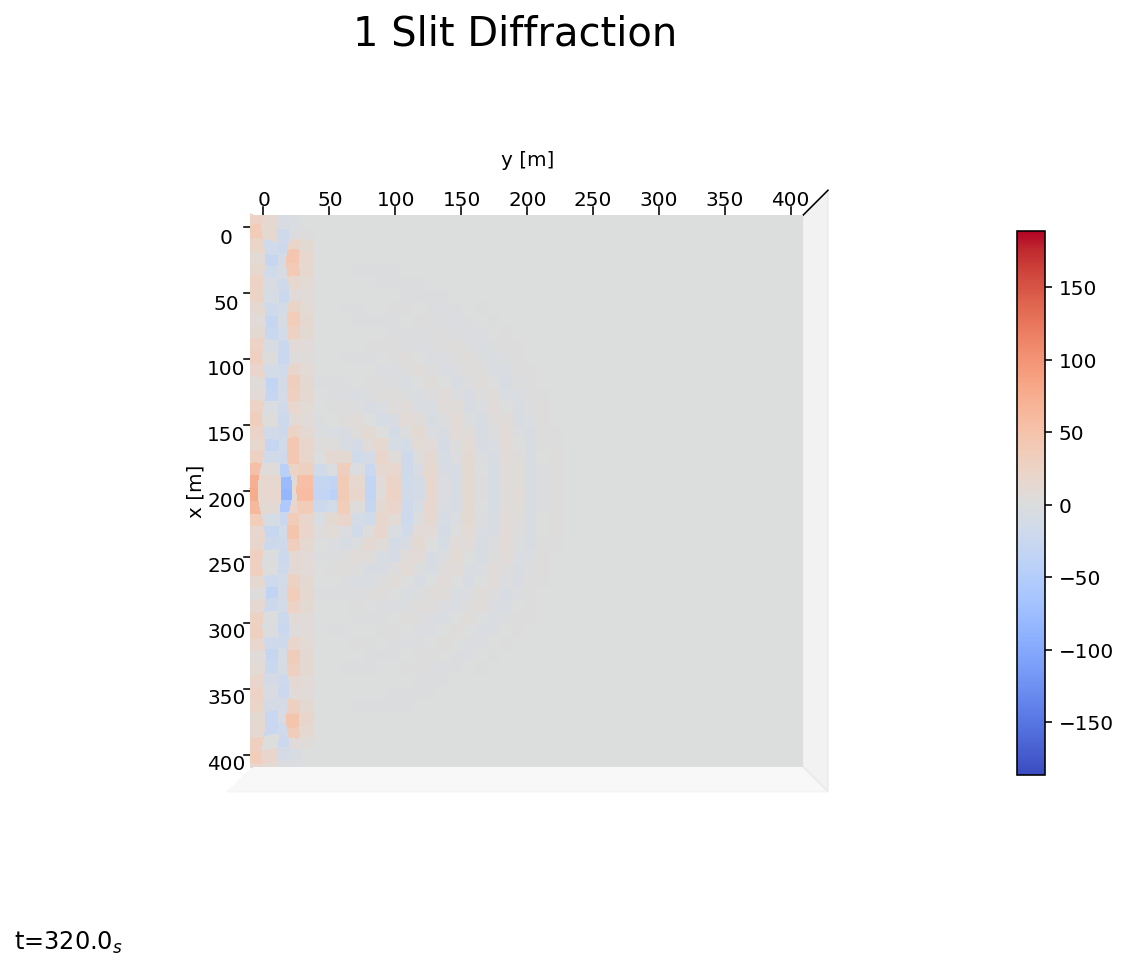

In [33]:
fig = plt.figure(figsize=(10, 10))
my_norm = colors.Normalize(vmin=np.amin(u), vmax=np.amax(u))  # יצירת נורמל, שישמור על צבעים קבועים לאורך הסימולציה
ax = plt.axes(projection="3d", xlim=(x0, xf), ylim=(y0, yf), zlim=(np.amin(u), np.amax(u)))
x_i, y_i = np.meshgrid(x, y)
line = ax.plot_surface(x_i, y_i, u[-1], cmap=cm.coolwarm, linewidth=0, antialiased=False, norm=my_norm)  # יצירת הגרף

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zticks([])
ax.grid(False)
ax.set_title(GRAPH_TITLE, fontsize=20)
fig.colorbar(cm.ScalarMappable(norm=my_norm, cmap=cm.coolwarm), ax=ax, shrink=0.5)  # הוספת מקרא צבעים

# הוספת טקסט של הזמן הנוכחי
time = f"t={t[-1]}$_{{{'s'}}}$"
txt = plt.figtext(0, 0, time, wrap=True, horizontalalignment='center', fontsize=12, transform = ax.transAxes)

ax.view_init(90, 0)  # הגדרת זווית הצפייה בגרף
plt.show()

In [34]:
def init():
    line = ax.plot_surface(x_i, y_i, u[0], cmap=cm.coolwarm, linewidth=0, antialiased=False, norm=my_norm)
    return line,

In [35]:
def animate(i):
    ax.clear()
    line = ax.plot_surface(x_i, y_i, u[i], cmap=cm.coolwarm, linewidth=0, antialiased=False, norm=my_norm)
    ax.set_zlim((np.amin(u), np.amax(u)))
    txt.set_text(f"t={t[i]}$_{{{'s'}}}$")  # עדכון הזמן על המסך
    return line,

In [36]:
if CREATE_VIDEO:
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=M, interval=10, blit=True)
    anim.save(f'{VIDEO_NAME}.mp4', fps=30, extra_args=('-vcodec', 'libx264'))
    plt.show()